<a href="https://colab.research.google.com/github/shab-sa/cs_internship/blob/main/Step12_ImageCaptioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
! kaggle datasets download hsankesara/flickr-image-dataset

Dataset URL: https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset
License(s): CC0-1.0
100% 8.15G/8.16G [01:31<00:00, 74.7MB/s]
100% 8.16G/8.16G [01:31<00:00, 95.8MB/s]


In [4]:
! unzip flickr-image-dataset.zip &>/dev/null &

In [5]:
import pandas as pd

In [10]:
df = pd.read_csv('/content/flickr30k_images/results.csv',delimiter="|", on_bad_lines='skip')
df.head(10)

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .
5,10002456.jpg,0,Several men in hard hats are operating a gian...
6,10002456.jpg,1,Workers look down from up above on a piece of...
7,10002456.jpg,2,Two men working on a machine wearing hard hats .
8,10002456.jpg,3,Four men on top of a tall structure .
9,10002456.jpg,4,Three men on a large rig .


In [11]:
import pathlib
imgdir_path = pathlib.Path('/content/flickr30k_images/flickr30k_images')
file_list = sorted([str(path) for path in imgdir_path.glob('*.jpg')])
print(len(file_list))

31783


Image shape:  (500, 333, 3)


NameError: name 'os' is not defined

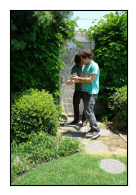

In [14]:
import matplotlib.pyplot as plt
import tensorflow as tf
fig = plt.figure(figsize=(10, 5))
for i, file in enumerate(file_list[:6]):
  img_raw = tf.io.read_file(file)
  img = tf.image.decode_image(img_raw)
  print('Image shape: ', img.shape)
  ax = fig.add_subplot(2, 3, i+1)
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(img)
  ax.set_title(os.path.basename(file), size=15)
plt.tight_layout()
plt.show()